Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
import collections
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Read the Human Proteome

In [ ]:
# Download from uniprot: https://www.uniprot.org/help/human_proteome
!wget -O uniprot.fasta "https://www.uniprot.org/uniprot/?query=reviewed%3Ayes+AND+proteome%3Aup000005640&format=fasta"

--2021-06-07 19:25:35--  https://www.uniprot.org/uniprot/?query=reviewed%3Ayes+AND+proteome%3Aup000005640&format=fasta
Resolving www.uniprot.org (www.uniprot.org)... 193.62.192.81
Connecting to www.uniprot.org (www.uniprot.org)|193.62.192.81|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [text/plain]
Saving to: ‘uniprot.fasta’

uniprot.fasta           [     <=>            ]  12.98M  1.48MB/s    in 8.2s    

2021-06-07 19:25:43 (1.58 MB/s) - ‘uniprot.fasta’ saved [13606528]



In [ ]:
def fasta_iterator(file_handle):
  partial_sequence = ''
  line = file_handle.readline()
  while line:
    if line.startswith('>'):
      if partial_sequence:
        yield partial_sequence
        partial_sequence = ''
    else:
      partial_sequence += line.strip()
    line = file_handle.readline()
  if partial_sequence:
    yield partial_sequence

def read_seqs_from_fasta(filepath):
  all_seqs = []
  with open(filepath, 'rt') as f:
    for seq in fasta_iterator(f):
      all_seqs.append(seq)
  print('Read %d entries from %s' % (len(all_seqs), filepath))
  return all_seqs

full_seqs = read_seqs_from_fasta('uniprot.fasta')

Read 20380 entries from uniprot.fasta


#LysC digestion

In [ ]:
LYSINE = 'K'

def lys_c_digest(protein_sequence):
  """Return the pieces of a sequence after Lys-C digestion."""
  pieces = []
  last_cut_pos = len(protein_sequence)
  for i in reversed(range(len(protein_sequence) - 1)):
    current_char = protein_sequence[i]

    if current_char == LYSINE:
      piece = protein_sequence[i + 1:last_cut_pos + 1]
      pieces.append(piece)
      last_cut_pos = i

  if last_cut_pos >= 0:
    piece = protein_sequence[0:last_cut_pos + 1]
    pieces.append(piece)

  return list(reversed(pieces))

def make_fragment_df(seqs):
  tuples = []
  for protein_num, seq in enumerate(seqs):
    digested_fragments = lys_c_digest(seq)
    for fragment_num, fragment in enumerate(digested_fragments):
      tuples.append((protein_num, fragment_num, fragment))
  df = pd.DataFrame.from_records(tuples, columns=('protein_num', 'fragment_num', 'raw_fragment'))
  df['fragment_len'] = df['raw_fragment'].str.len()
  return df

full_fragment_df = make_fragment_df(full_seqs)
full_fragment_df

,protein_num,fragment_num,raw_fragment,fragment_len
0,0,0,MWLSPEEVLVANALWVTERANPFFVLQRRRGHGRGGGLTGLLVGTL...,81
1,0,1,EITK,4
2,0,2,HWEWLENNLLQTLSIFDSEEDITTFVK,27
3,0,3,GK,2
4,0,4,IHGIIAEENK,10
...,...,...,...,...
670057,20379,65,NEEDK,5
670058,20379,66,LK,2
670059,20379,67,DWEGGLDEQRLSADSGYIIPLPDIDPVPEEEDLGK,35
670060,20379,68,RNRHSSQTSEESAIETGSSSSTFIK,25


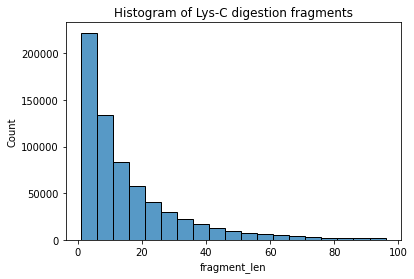

In [ ]:
_ = sns.histplot(full_fragment_df, x='fragment_len', bins=range(1, 100, 5))
_ = plt.title('Histogram of Lys-C digestion fragments')

In [ ]:
num_proteins_total = full_fragment_df['protein_num'].nunique()
num_proteins_total

20380

# Generate binder sets

In [ ]:
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')
dipeptides = [x + y for x in amino_acids for y in amino_acids]
len(dipeptides)

400

In [ ]:
BINDER_SEP = '-'
TARGET_SEP = ':'

def generate_binder_set(num_dipeptides, num_binder):
  binder_list = []
  for _ in range(num_binder):
    # Each binder will bind to a random selection of dipeptide targets.
    targets = np.random.choice(dipeptides, size=num_dipeptides, replace=False)
    binder = TARGET_SEP.join(targets)
    binder_list.append(binder)
  binder_set = BINDER_SEP.join(binder_list)
  return binder_set

In [ ]:
np.random.seed(12345) # Set random seed for deterministic behavior
binder_set = generate_binder_set(num_dipeptides=2, num_binder=3)
print(binder_set)

WW:KS-FI:AF-SW:AT


A binder set is chosen randomly and is represented by a string.

The character - separates each binder.

The character : separates the dipeptide targets that a binder binds to.

So, if the binder set is WW:KS_FI:AF_SW:AT then there are three binders. The first binds to WW and KS. The second binds to FI and AF. The third binds to SW and AT.

# Read a fragment as barcodes using a binder set 

In [ ]:
# Make fragments padded to constant length using non-amino acid overflow character
READ_OVERFLOW = 'Z'
max_len = full_fragment_df['fragment_len'].max()
full_fragment_df['padded_fragment'] = full_fragment_df['raw_fragment'].str.pad(max_len, side='right', fillchar=READ_OVERFLOW)
full_fragment_df

,protein_num,fragment_num,raw_fragment,fragment_len,padded_fragment
0,0,0,MWLSPEEVLVANALWVTERANPFFVLQRRRGHGRGGGLTGLLVGTL...,81,MWLSPEEVLVANALWVTERANPFFVLQRRRGHGRGGGLTGLLVGTL...
1,0,1,EITK,4,EITKZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
2,0,2,HWEWLENNLLQTLSIFDSEEDITTFVK,27,HWEWLENNLLQTLSIFDSEEDITTFVKZZZZZZZZZZZZZZZZZZZ...
3,0,3,GK,2,GKZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
4,0,4,IHGIIAEENK,10,IHGIIAEENKZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
...,...,...,...,...,...
670057,20379,65,NEEDK,5,NEEDKZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
670058,20379,66,LK,2,LKZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZZ...
670059,20379,67,DWEGGLDEQRLSADSGYIIPLPDIDPVPEEEDLGK,35,DWEGGLDEQRLSADSGYIIPLPDIDPVPEEEDLGKZZZZZZZZZZZ...
670060,20379,68,RNRHSSQTSEESAIETGSSSSTFIK,25,RNRHSSQTSEESAIETGSSSSTFIKZZZZZZZZZZZZZZZZZZZZZ...


In [ ]:
NO_BARCODE = '_'

def get_barcode_dict(binder_set):
  '''Convert a binder set into a dict that gives the binder for a target.'''
  barcode_dict = collections.defaultdict(lambda: NO_BARCODE)
  for i, binder in enumerate(binder_set.split(BINDER_SEP)):
    for target in binder.split(TARGET_SEP):
      barcode_dict[target] = str(i)
      # More than one binder could bind to the same target.
      # To get a lower bound on the number of proteins identified map the target
      # to just one of the binders.
  return barcode_dict

In [ ]:
barcode_dict = get_barcode_dict(binder_set)
print(barcode_dict)

defaultdict(<function get_barcode_dict.<locals>.<lambda> at 0x7f00b2a49320>, {'WW': '0', 'KS': '0', 'FI': '1', 'AF': '1', 'SW': '2', 'AT': '2'})


In [ ]:
DIPEPTIDE_LEN = 2

def get_barcode_read(fragment, read_length, binder_set):
  barcode_dict = get_barcode_dict(binder_set)
  return ''.join(barcode_dict[fragment[i:i+DIPEPTIDE_LEN]] for i in range(read_length))


In [ ]:
binder_set = 'WW:KS-FI:AF-SW:AT'
fragment = 'RSWWAFDDDAFDDDDD'  # Made up for illustrative purposes.
barcode_read = get_barcode_read(fragment, 12, binder_set)
print(barcode_read)

_20_1____1__


In this example the the fragment 'RSWWAFDDDAFDDDDD' is read using the binder set 'WW:KS-FI:AF-SW:AT'. There are 12 binding cycles each ending with a single amino acid removed by edman degradation.

```

example_fragment = 'RSWWAFDDDAFDDDDD'
example_binder_set = 'WW:KS-FI:AF-SW:AT'
binder_dict = {
    'AF': '1',
    'AT': '2',
    'FI': '1',
    'KS': '0',
    'SW': '2',
    'WW': '0'
    }

# read result is '_20_1____1__'
```

On the first cycle, the end dipeptide is RS. There is no binder in the set for that dipeptide target so no barcode is left for that cycle.

On the next cycle, the end dipeptide is SW (the R has been removed). Binder #2 targets that dipeptide and so the bacode '2' is left. The barcode sequence would indicate both binder and cycle number.

On the next cycle, the end dipeptide is WW (the S has been removed). Binder #0 targets that dipeptide and so the bacode '0' is left.

The process continues until the last cycle number. The barcodes read would be: Binder #2 on cycle 2, Binder #0 on cycle 3, Binder #1 on cycle 5, Binder #1 on cycle 10. This is represented here as the string '_20_1____1__'.

A fragement is matched to a specific protein if the barcode read is unique i.e. no other protein fragment gets the same barcode sequence read.


# Fraction of proteome identified by different binder sets

In [ ]:
READ_LENGTH = 12

def try_binder_set(binder_set):
  full_fragment_df['temp_read'] = full_fragment_df['padded_fragment'].apply(lambda x: get_barcode_read(x, READ_LENGTH, binder_set))
  # Handle the case where a read appears multiple times in the same protein.
  temp_fragment_df = full_fragment_df.drop_duplicates(
      subset=['temp_read', 'protein_num'], keep='first')
  num_identified_proteins = temp_fragment_df.drop_duplicates(subset='temp_read', keep=False)['protein_num'].nunique()
  return num_identified_proteins

In [ ]:
# Look at the performance for a binder set.
binder_set = 'WW:KS-FI:AF-SW:AT'
print('binder_set = ', binder_set)
num_identified_proteins = try_binder_set(binder_set)
print('num_identified_proteins = ', num_identified_proteins)
print("Proteome identified: {:.1%}".format(1. * num_identified_proteins / num_proteins_total))

binder_set =  WW:KS-FI:AF-SW:AT
num_identified_proteins =  124
Proteome identified: 0.6%


In [ ]:
# Look at the performance for a larger binder set with more targets each.
num_dipeptides=8
print('num_dipeptides = ', num_dipeptides)
num_binder=10
print('num_binder = ', num_binder)
np.random.seed(12345) # Set random seed for deterministic behavior
binder_set = generate_binder_set(num_dipeptides=num_dipeptides, num_binder=num_binder)
print('binder_set = ', binder_set)
num_identified_proteins = try_binder_set(binder_set)
print('num_identified_proteins = ', num_identified_proteins)
print("Proteome identified: {:.1%}".format(1. * num_identified_proteins / num_proteins_total))

num_dipeptides =  8
num_binder =  10
binder_set =  WW:KS:YT:MQ:GM:SC:PM:YC-FI:AF:VA:QR:RA:PV:KM:TW-SW:AT:VL:VC:WR:AC:KD:NH-GQ:QA:HD:SK:SV:TH:MW:QR-VQ:VK:IH:CT:QR:IR:TS:DG-LR:EG:FW:QW:EC:CQ:NE:PA-DV:GE:AD:IT:ET:TP:YN:YF-NF:HD:DG:TM:AL:CY:VE:QY-LM:DV:AR:KT:MQ:EK:NR:CG-FE:VF:DE:EF:QK:ME:AQ:RC
num_identified_proteins =  17553
Proteome identified: 86.1%


# Evaluate proteome identification for binder sets with a range of properties

In [ ]:
results = []
np.random.seed(12345) # Set random seed for deterministic behavior

In [ ]:
# Small number of properties to evaluate (for faster run time).
RANGE_NUM_BINDERS_IN_SET = [1, 5, 10, 15]
RANGE_NUM_TARGETS_PER_BINDER = [1, 4, 8, 350]
NUM_SAMPLES_PER_CONDITION = 1

# Values used to generate the results in the paper.
# RANGE_NUM_BINDERS_IN_SET = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 25, 50, 75, 100]
# RANGE_NUM_TARGETS_PER_BINDER = [1, 2, 3, 4, 5, 6, 7, 8, 9, 25, 50, 100, 150, 200, 250, 300, 400]
# NUM_SAMPLES_PER_CONDITION = 20

In [ ]:
# This takes ~1 hour to run
for sample in range(NUM_SAMPLES_PER_CONDITION):
  for num_dipeptides in RANGE_NUM_TARGETS_PER_BINDER:
    for num_binder in RANGE_NUM_BINDERS_IN_SET:
      binder_set = generate_binder_set(num_dipeptides=num_dipeptides, num_binder=num_binder)
      num_identified_proteins = try_binder_set(binder_set)
      new_tuple = (num_binder, num_dipeptides, sample, binder_set, num_identified_proteins)
      results.append(new_tuple)
      print("num_binder=%d, num_dipeptides=%d, sample=%d, binder_set=%s, num_identified_proteins=%d" % new_tuple)
      print("{:.1%}".format(1. * num_identified_proteins / num_proteins_total))

num_binder=1, num_dipeptides=1, sample=0, binder_set=WW, num_identified_proteins=6
0.0%
num_binder=5, num_dipeptides=1, sample=0, binder_set=FI-SW-GQ-VQ-LR, num_identified_proteins=433
2.1%
num_binder=10, num_dipeptides=1, sample=0, binder_set=DV-NF-LM-FE-RN-IQ-TH-FK-CA-LQ, num_identified_proteins=1830
9.0%
num_binder=15, num_dipeptides=1, sample=0, binder_set=MG-PP-WN-ES-PN-CI-DL-PK-CH-IY-AH-GG-GK-IC-MS, num_identified_proteins=4019
19.7%
num_binder=1, num_dipeptides=4, sample=0, binder_set=TI:IH:ME:MN, num_identified_proteins=33
0.2%
num_binder=5, num_dipeptides=4, sample=0, binder_set=VT:LW:HP:AA-GP:ND:MP:LC-ES:HI:QK:SI-VS:HS:FY:DH-SR:CN:EY:IN, num_identified_proteins=3957
19.4%
num_binder=10, num_dipeptides=4, sample=0, binder_set=SE:YR:KE:LP-VR:IY:IE:CN-WM:IH:TE:EN-TD:WI:PW:YL-KR:HP:YT:CL-TY:CL:LG:LL-HQ:ND:YK:FV-TM:WL:AE:FE-TG:RA:IR:CA-YS:IA:YN:NT, num_identified_proteins=11668
57.3%
num_binder=15, num_dipeptides=4, sample=0, binder_set=KD:AN:VG:VR-TR:RP:WS:SI-YN:TQ:LG:IA-RI:NW:NT

In [ ]:
long_df = pd.DataFrame.from_records(results, columns=['num_binder', 'num_dipeptides', 'sample', 'binder_name', 'num_identified_proteins'])
long_df['proteome_fraction_identified'] = 1. * long_df['num_identified_proteins'] / num_proteins_total

In [ ]:
pivoted = long_df.pivot_table(values='proteome_fraction_identified', index='num_dipeptides', columns='num_binder', aggfunc='median')
pivoted.style.background_gradient(axis=None).format('{:.0%}')

num_binder,1,5,10,15
num_dipeptides,,,,
1,0%,2%,9%,20%
4,0%,19%,57%,81%
8,0%,41%,90%,95%
350,2%,23%,27%,33%


# Figure from the manuscript
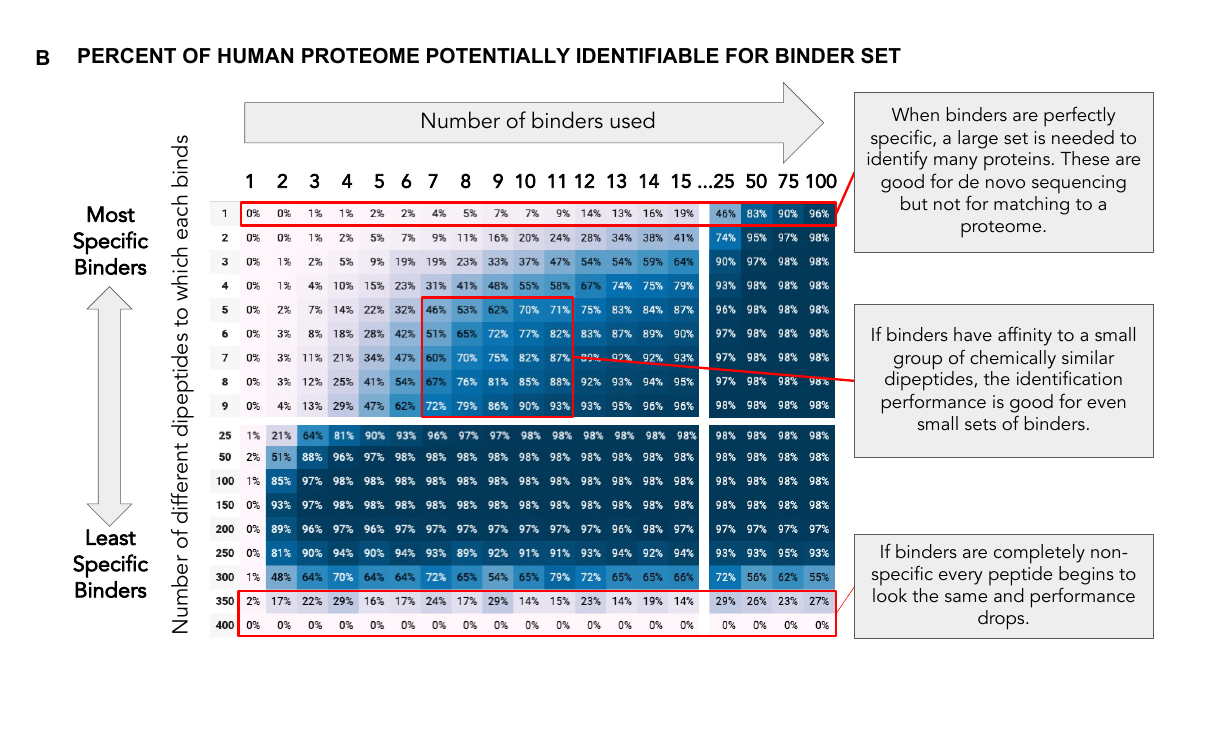